In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 74.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 20.1 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [3]:
# 📌 Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)

# 📌 Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)

# 📌 The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(torch_device)

# 📌 The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# 📌 ✅ To GPU We Go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# 📌 ✅ ADDING Stable Diffusion Pipeline
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to(torch_device)

print("✅ Stable Diffusion pipeline loaded and moved to GPU (if available)!")


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Stable Diffusion pipeline loaded and moved to GPU (if available)!


In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
# 📌 Set up the scheduler and initialize latents

# Set number of sampling steps
num_inference_steps = 50  # More steps = better image quality
guidance_scale = 7.5  # Strength of text guidance
batch_size = 1  # Generate one image at a time

# Prep the scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Initialize noise (random latents)
generator = torch.manual_seed(42)  # Ensures reproducibility
latents = torch.randn((batch_size, unet.in_channels, 512 // 8, 512 // 8), generator=generator).to(torch_device)
latents = latents * scheduler.init_noise_sigma  # Scale latents properly

print("✅ Scheduler and latents initialized successfully!")


✅ Scheduler and latents initialized successfully!


<ipython-input-6-0d4545ca3e77>:13: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, 512 // 8, 512 // 8), generator=generator).to(torch_device)


In [7]:
# 📌 Load the 5 selected styles from the `.bin` files

style_paths = {
    "midjourney": "/kaggle/input/stable-diffusion/midjourney.bin",
    "concept_art": "/kaggle/input/stable-diffusion/concept_art.bin",
    "cosmic_galaxy": "/kaggle/input/stable-diffusion/cosmic_galaxy.bin",  
    "fireworks": "/kaggle/input/stable-diffusion/fireworks_over_water.bin",
    "moeb_style": "/kaggle/input/stable-diffusion/moeb_style.bin"
}

# Load each style embedding
for style_name, style_path in style_paths.items():
    pipe.load_textual_inversion(style_path)
    print(f"✅ Loaded style: {style_name}")

print("✅ All styles loaded successfully!")


✅ Loaded style: midjourney
✅ Loaded style: concept_art
✅ Loaded style: cosmic_galaxy
✅ Loaded style: fireworks
✅ Loaded style: moeb_style
✅ All styles loaded successfully!


In [21]:
# 7.py - Generate images WITHOUT loss

import torch
from tqdm.auto import tqdm

prompt = "Birds in a garden"  # Modify prompt as needed
generated_images_without_loss = []

# Define different seeds for each style
style_seeds = {
    "midjourney": 42,
    "concept_art": 100,
    "cosmic_galaxy": 200,
    "fireworks": 300,
    "moeb_style": 400
}

for style_name in style_paths.keys():
    print(f"Generating image in {style_name} style...")
    
    # Reset scheduler for each style
    scheduler.set_timesteps(num_inference_steps)

    # Use different seed for each style
    generator = torch.Generator(device=torch_device)
    generator.manual_seed(style_seeds[style_name])

    # Encode text prompt
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
    print(f"🔹 Initial Text Embeddings Shape: {text_embeddings.shape}")

    # Prepare unconditional (empty) embeddings
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    print(f"🔹 Unconditional Embeddings Shape: {uncond_embeddings.shape}")

    # Concatenate unconditional and text embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    print(f"🔹 Combined Text Embeddings Shape: {text_embeddings.shape}")

    # Initialize new latents for each style
    latents = torch.randn(
        (batch_size, unet.config.in_channels, 64, 64),
        generator=generator,
        device=torch_device
    )
    latents = latents * scheduler.init_noise_sigma
    print(f"🔹 Initial Latents Shape: {latents.shape}")

    # Denoising loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # Double the latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        print(f"🔹 Doubled Latents Shape: {latent_model_input.shape}") if i == 0 else None
        
        # Scale the latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        print(f"🔹 Scaled Latents Shape: {latent_model_input.shape}") if i == 0 else None

        # Predict noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
        print(f"🔹 Noise Prediction Shape: {noise_pred.shape}") if i == 0 else None

        # Perform classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Convert latents to image
    image = latents_to_pil(latents)[0]
    generated_images_without_loss.append(image)
    image.show()

print("✅ All images generated WITHOUT loss!")

Generating image in midjourney style...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in concept_art style...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in cosmic_galaxy style...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in fireworks style...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in moeb_style style...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
✅ All images generated WITHOUT loss!


Displaying images WITHOUT loss:


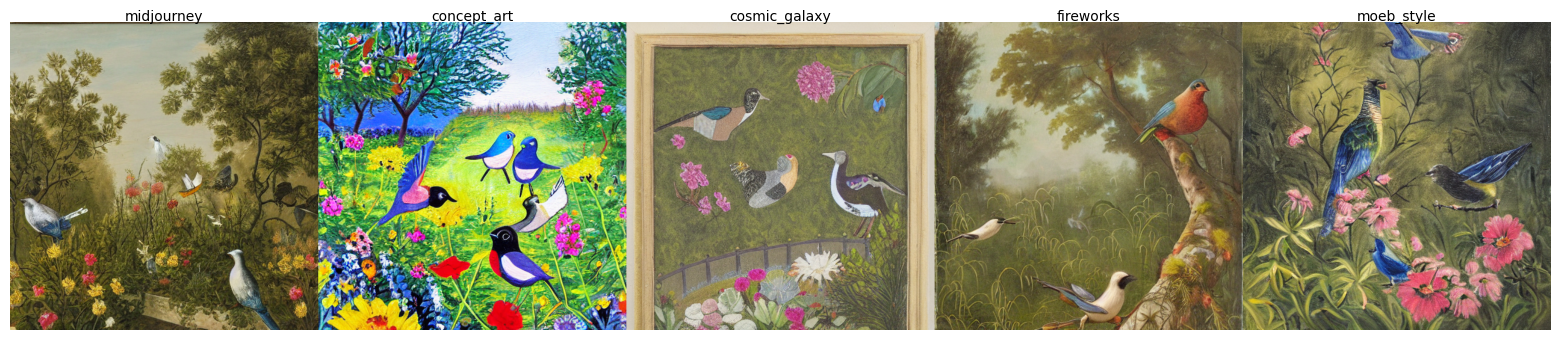

In [22]:
print("Displaying images WITHOUT loss:")
image_grid(generated_images_without_loss, rows=1, cols=5, titles=style_paths.keys())

In [ ]:
# 8.py - creative loss function
import torch
import torch.nn.functional as F

def artistic_enhancement_loss(latents):
    """
    Advanced Enhancement Loss:
    - Enhances edges (Sobel + Laplacian)
    - Adds cinematic tilt-shift effect (Gaussian blur)
    - Deep focus: Sharpen center, blur sides
    - Vignette effect for artistic look
    """
    with torch.no_grad():
        scaled_latents = 1 / 0.18215 * latents  # Convert latents back to pixel space
        images = vae.decode(scaled_latents).sample  # Decode latents to images

    images = (images + 1) / 2  # Normalize to [0,1]

    # === 1. Edge Detection ===
    grayscale = images.mean(dim=1, keepdim=True)  # Convert to grayscale
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=images.device).float().view(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], device=images.device).float().view(1, 1, 3, 3)
    edge_x = F.conv2d(grayscale, sobel_x, padding=1)
    edge_y = F.conv2d(grayscale, sobel_y, padding=1)
    edges = torch.sqrt(edge_x ** 2 + edge_y ** 2)

    # Extra enhancement with Laplacian filter
    laplacian_filter = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], device=images.device).float()
    laplacian_edges = F.conv2d(grayscale, laplacian_filter, padding=1)
    edges = torch.clamp(edges + laplacian_edges * 0.5, 0, 1)  # Boost edges

    # === 2. Tilt-Shift Blur (Gaussian) ===
    kernel_size = 9
    sigma = 4.0
    kernel_range = torch.linspace(-(kernel_size//2), kernel_size//2, kernel_size, device=images.device)
    x_kernel, y_kernel = torch.meshgrid(kernel_range, kernel_range, indexing='ij')
    gaussian_kernel = torch.exp(-(x_kernel**2 + y_kernel**2) / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)

    blurred_channels = []
    for c in range(images.shape[1]):
        blurred_channel = F.conv2d(images[:, c:c+1, :, :], gaussian_kernel, padding=kernel_size//2)
        blurred_channels.append(blurred_channel)
    blurred = torch.cat(blurred_channels, dim=1)

    # Blend sharp image with blurred image based on edges
    blur_weight = torch.exp(-edges * 8)  # Stronger edges → less blur
    background_blurred = images * blur_weight + blurred * (1 - blur_weight)

    # === 3. Deep Focus Effect (Sharpen Center, Blur Sides) ===
    y, x = torch.meshgrid(torch.linspace(-1, 1, images.shape[2], device=images.device),
                           torch.linspace(-1, 1, images.shape[3], device=images.device))
    distance_from_center = torch.sqrt(x**2 + y**2)
    focus_mask = torch.exp(-distance_from_center * 7).unsqueeze(0).unsqueeze(0)
    deep_focus = images * focus_mask + background_blurred * (1 - focus_mask)

    # === 4. Vignette Effect ===
    vignette = 1.0 - torch.clamp(distance_from_center * 0.7, 0, 1)
    vignette = vignette.unsqueeze(0).unsqueeze(0)
    deep_focus = deep_focus * vignette

    # === 5. Cartoonify: Stronger Contrast + Edges ===
    cartoonified = deep_focus + edges * 0.3  # Strengthen edges
    cartoonified = torch.clamp(cartoonified, 0, 1)

    # === 6. Compute Loss ===
    loss = torch.pow(images - cartoonified, 2).mean()

    # === 7. Compute Gradient for Optimization ===
    latent_grad = torch.ones_like(latents) * 0.1  # Controls gradient effect
    latent_grad *= min(0.7, loss.item() * 1.5)

    return loss * 5.0, latent_grad


In [ ]:
# 9.py - Generate images WITH loss
generated_images_with_loss = []

# Use the same seeds for consistency
style_seeds = {
    "midjourney": 42,
    "concept_art": 100,
    "cosmic_galaxy": 200,
    "fireworks": 300,
    "moeb_style": 400
}

for style_name in style_paths.keys():
    print(f"Generating image in {style_name} style WITH loss...")
    
    # Reset scheduler for each style
    scheduler.set_timesteps(num_inference_steps)

    # Use different seed for each style
    generator = torch.Generator(device=torch_device)
    generator.manual_seed(style_seeds[style_name])

    # Encode text prompt
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
    print(f"🔹 Initial Text Embeddings Shape: {text_embeddings.shape}")

    # Prepare unconditional (empty) embeddings
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    print(f"🔹 Unconditional Embeddings Shape: {uncond_embeddings.shape}")

    # Concatenate unconditional and text embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    print(f"🔹 Combined Text Embeddings Shape: {text_embeddings.shape}")

    # Initialize new latents for each style
    latents = torch.randn(
        (batch_size, unet.config.in_channels, 64, 64),
        generator=generator,
        device=torch_device
    )
    latents = latents * scheduler.init_noise_sigma
    print(f"🔹 Initial Latents Shape: {latents.shape}")

    # Denoising loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # Double the latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        print(f"🔹 Doubled Latents Shape: {latent_model_input.shape}") if i == 0 else None

        # Scale the latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        print(f"🔹 Scaled Latents Shape: {latent_model_input.shape}") if i == 0 else None

        # Apply custom loss function to the original latents (not the doubled version)
        with torch.enable_grad():
            latents_for_loss = latents.detach().requires_grad_()
            loss, direct_grad = artistic_enhancement_loss(latents_for_loss)
            # Apply gradient with moderate effect (reduced from 1.5)
            latents = latents - 0.9 * direct_grad

        # Predict noise residual with the updated latents
        latent_model_input = torch.cat([latents] * 2)  # Double the updated latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
        print(f"🔹 Noise Prediction Shape: {noise_pred.shape}") if i == 0 else None

        # Perform classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Convert latents to image
    image = latents_to_pil(latents)[0]
    generated_images_with_loss.append(image)
    image.show()

print("✅ All images generated WITH loss!")

Generating image in midjourney style WITH loss...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in concept_art style WITH loss...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in cosmic_galaxy style WITH loss...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in fireworks style WITH loss...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
Generating image in moeb_style style WITH loss...
🔹 Initial Text Embeddings Shape: torch.Size([1, 77, 768])
🔹 Unconditional Embeddings Shape: torch.Size([1, 77, 768])
🔹 Combined Text Embeddings Shape: torch.Size([2, 77, 768])
🔹 Initial Latents Shape: torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Doubled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Scaled Latents Shape: torch.Size([2, 4, 64, 64])
🔹 Noise Prediction Shape: torch.Size([2, 4, 64, 64])
✅ All images generated WITH loss!


Displaying images WITHOUT loss:


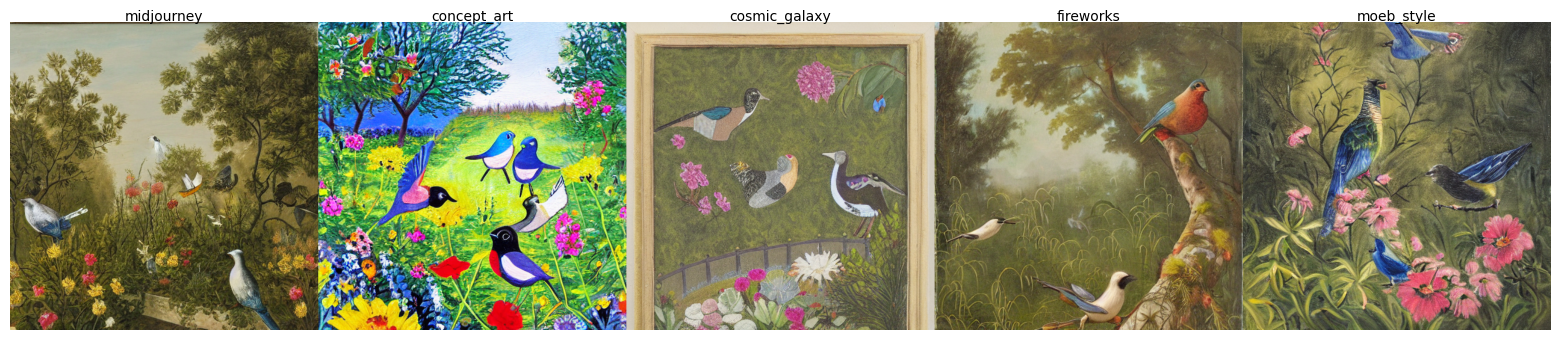

Displaying images WITH loss:


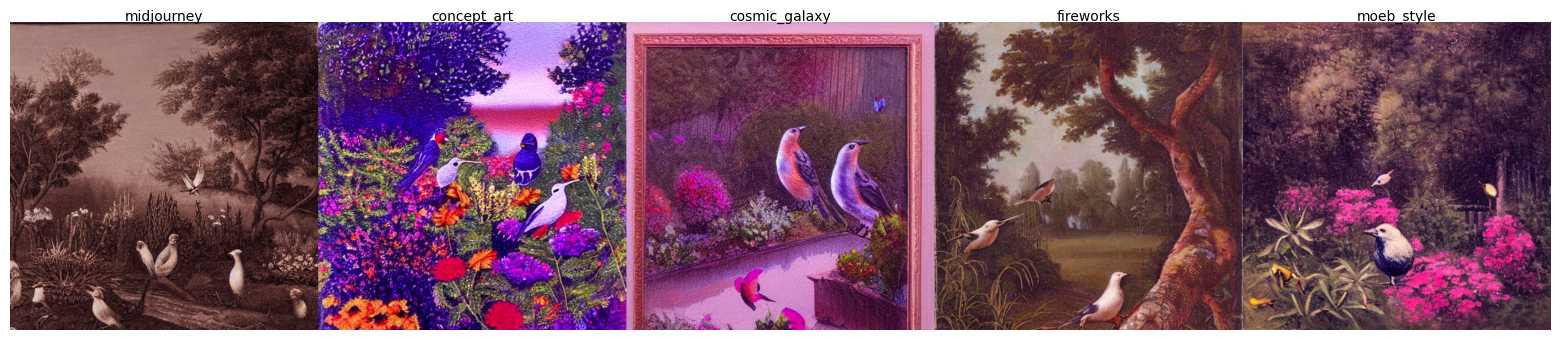

✅ Final comparison complete!


In [27]:
# 📌 Final step: Display all images side by side for comparison

def image_grid(imgs, rows, cols, titles=None):
    assert len(imgs) == rows * cols
    
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    
    # Create a figure and axis
    plt.figure(figsize=(20, 4))
    plt.imshow(grid)
    
    # Add titles if provided
    if titles:
        for i, title in enumerate(titles):
            plt.text(i*w + w/2, -10, title, 
                    horizontalalignment='center',
                    verticalalignment='center')
    
    plt.axis('off')
    plt.show()

print("Displaying images WITHOUT loss:")
image_grid(generated_images_without_loss, rows=1, cols=5, titles=style_paths.keys())

print("Displaying images WITH loss:")
image_grid(generated_images_with_loss, rows=1, cols=5, titles=style_paths.keys())

print("✅ Final comparison complete!")